<a href="https://colab.research.google.com/github/BayramovaNazrin/illicit-btc-detection/blob/main/supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, average_precision_score
)

sns.set_theme(style='whitegrid', context='talk')


In [2]:
# Save images
import os
save_dir = "/content/illicit-btc-detection/visuals/classical_models"
os.makedirs(save_dir, exist_ok=True)

# **Load Data**

In [13]:
%cd /content
!git clone https://github.com/BayramovaNazrin/illicit-btc-detection.git
%cd /content/illicit-btc-detection

/content
Cloning into 'illicit-btc-detection'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 205 (delta 30), reused 14 (delta 14), pack-reused 158 (from 1)
Receiving objects: 100% (205/205), 7.16 MiB | 7.95 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/illicit-btc-detection


In [23]:
import sys
sys.path.append('/content/illicit-btc-detection')

from load_data import load_data
features, edges, classes, merged_df = load_data()

#  **Separate unknown and known instances**

In [20]:
# --- Separate known and unknown transactions ---
df_known = merged_df[merged_df['class'].notna()].copy()
df_unknown = merged_df[merged_df['class'].isna()].copy()

# --- Clean labels ---
df_known['class'] = df_known['class'].astype(int)

# --- Feature columns ---
feature_cols = [c for c in merged_df.columns if c.startswith('feature_')]

# **Define Training and Evaluation Function**

In [21]:
def train_and_evaluate(model, model_name):
    X = df_known[feature_cols]
    y = df_known['class'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=[2,1])
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['Pred Licit (2)', 'Pred Illicit (1)'],
                yticklabels=['True Licit (2)', 'True Illicit (1)'])
    plt.title(f"{model_name} - Confusion Matrix")
    filename = f"{save_dir}/{model_name.lower().replace(' ', '_')}_confusion.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved plot to: {filename}")
    plt.show()

    return pipeline, X_test, y_test


# **Run Models**

## Random Forest


=== Random Forest ===
Accuracy: 0.987973800064426
F1 (weighted): 0.9878589944346976
              precision    recall  f1-score   support

           1     0.9575    0.9175    0.9371       909
           2     0.9911    0.9956    0.9934      8404

    accuracy                         0.9880      9313
   macro avg     0.9743    0.9565    0.9652      9313
weighted avg     0.9878    0.9880    0.9879      9313

✅ Saved plot to: /content/illicit-btc-detection/visuals/classical_models/random_forest_confusion.png


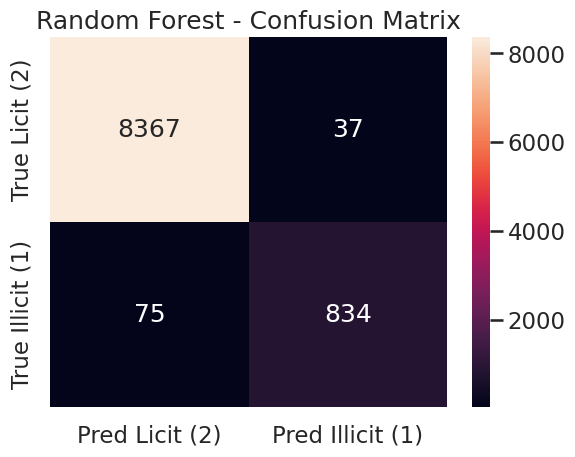

In [22]:
rf_model, X_test, y_test = train_and_evaluate(
    RandomForestClassifier(
        random_state=42, class_weight='balanced',
        n_estimators=200, max_depth=10
    ),
    "Random Forest"
)


Class order in predict_proba: [1 2]
ROC-AUC: 0.9953
PR-AUC : 0.9762


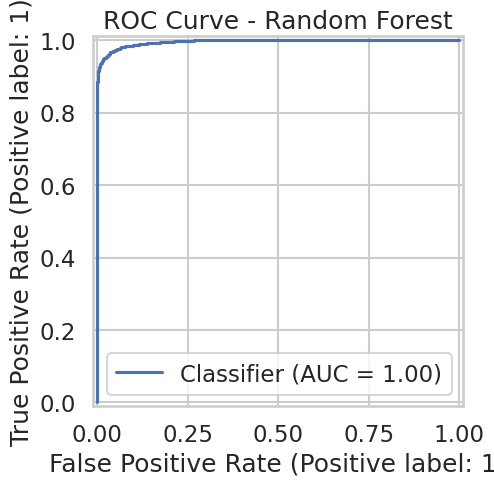

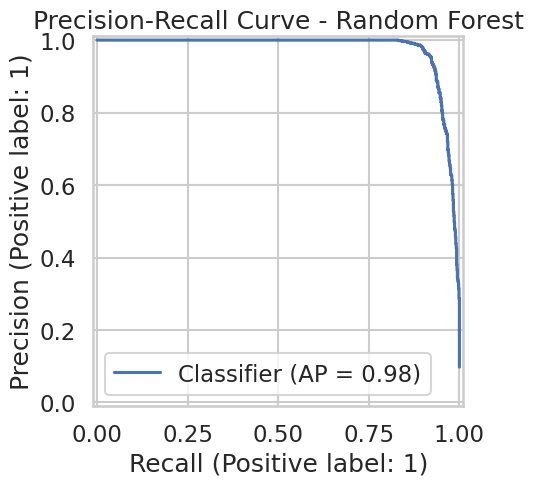

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

# --- Check class order ---
print("Class order in predict_proba:", rf_model.classes_)

# --- Get probabilities ---
proba = rf_model.predict_proba(X_test)
if rf_model.classes_[0] == 1:
    y_prob_illicit = proba[:, 0]
else:
    y_prob_illicit = proba[:, 1]

# --- Compute metrics ---
roc_auc = roc_auc_score((y_test == 1), y_prob_illicit)
pr_auc  = average_precision_score((y_test == 1), y_prob_illicit)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")

# --- Optional visualization ---
RocCurveDisplay.from_predictions((y_test == 1), y_prob_illicit)
plt.title("ROC Curve - Random Forest")
plt.savefig(f"{save_dir}/rf_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

PrecisionRecallDisplay.from_predictions((y_test == 1), y_prob_illicit)
plt.title("Precision-Recall Curve - Random Forest")
plt.savefig(f"{save_dir}/rf_pr_curve.png", dpi=300, bbox_inches='tight')
plt.show()


## Support Vector Machines (SVM)


=== SVM ===
Accuracy: 0.9547943734564587
F1 (weighted): 0.9574359821494369
              precision    recall  f1-score   support

           1     0.7050    0.9230    0.7994       909
           2     0.9914    0.9582    0.9745      8404

    accuracy                         0.9548      9313
   macro avg     0.8482    0.9406    0.8870      9313
weighted avg     0.9634    0.9548    0.9574      9313

✅ Saved plot to: /content/test1/visuals/classical_models/svm_confusion.png


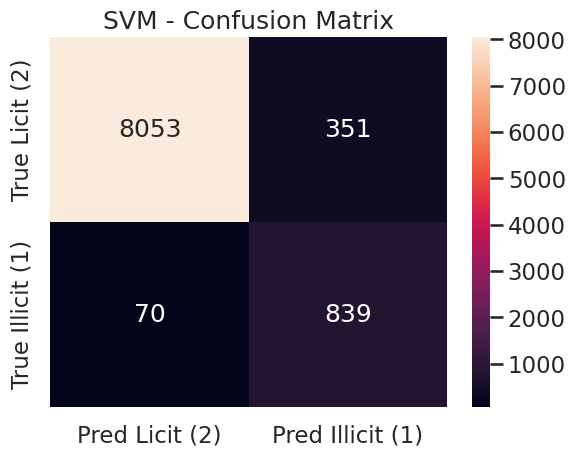

In [ ]:
svm_model, X_test, y_test = train_and_evaluate(
    SVC(kernel='rbf', random_state=42, class_weight='balanced'),
    "SVM"
)

## AdaBoost


=== AdaBoost ===
Accuracy: 0.9780951358316332
F1 (weighted): 0.9774856451422842
              precision    recall  f1-score   support

           1     0.9390    0.8295    0.8808       909
           2     0.9818    0.9942    0.9879      8404

    accuracy                         0.9781      9313
   macro avg     0.9604    0.9118    0.9344      9313
weighted avg     0.9776    0.9781    0.9775      9313

✅ Saved plot to: /content/test1/visuals/classical_models/adaboost_confusion.png


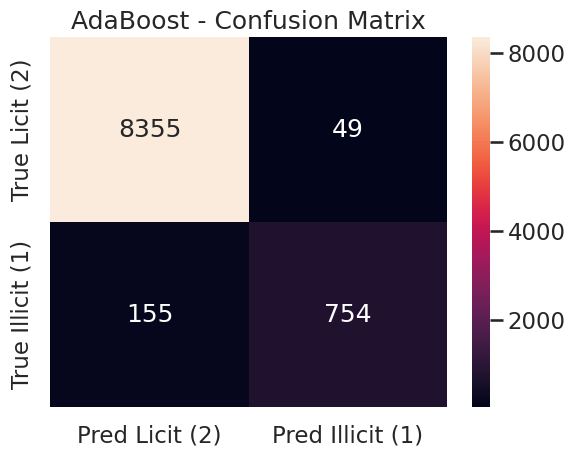

In [ ]:
ada_model, X_test, y_test = train_and_evaluate(
    AdaBoostClassifier(random_state=42, n_estimators=150),
    "AdaBoost"
)

# **Predict Unknown Transactions**

## Random Forest

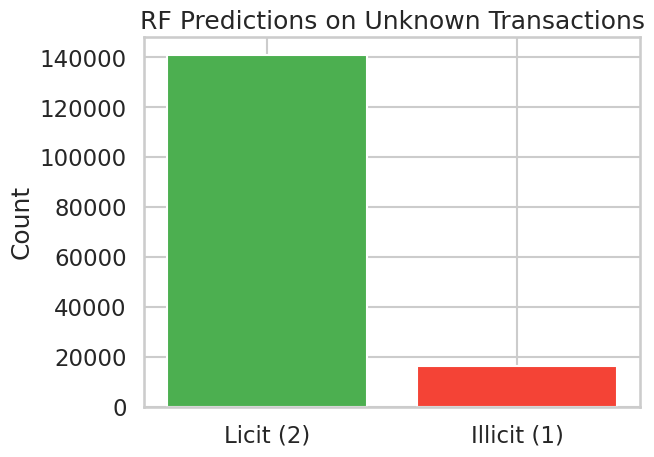

In [ ]:
X_unknown = df_unknown[feature_cols]
unknown_pred = rf_model.predict(X_unknown)

licit_count = np.count_nonzero(unknown_pred == 2)
illicit_count = np.count_nonzero(unknown_pred == 1)

plt.bar(["Licit (2)", "Illicit (1)"], [licit_count, illicit_count],
        color=['#4caf50','#f44336'])
plt.ylabel("Count")
plt.title("RF Predictions on Unknown Transactions")
plt.savefig(f"{save_dir}/rf_prediction.png", dpi=300, bbox_inches="tight")
plt.show()


## Support Vector Machines (SVM)

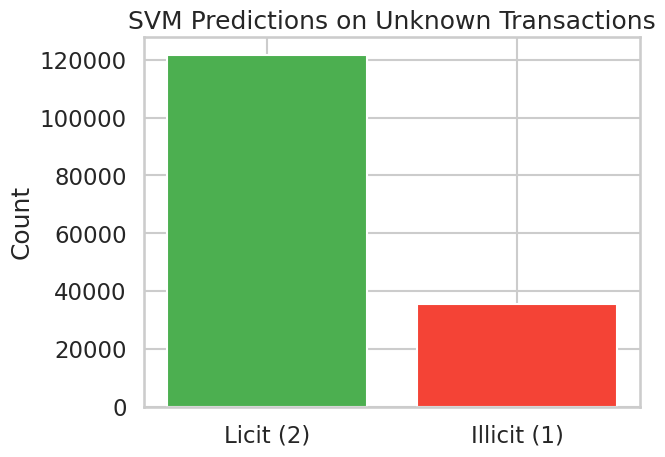

In [ ]:
X_unknown = df_unknown[feature_cols]
unknown_pred = svm_model.predict(X_unknown)

licit_count = np.count_nonzero(unknown_pred == 2)
illicit_count = np.count_nonzero(unknown_pred == 1)

plt.bar(["Licit (2)", "Illicit (1)"], [licit_count, illicit_count],
        color=['#4caf50','#f44336'])
plt.ylabel("Count")
plt.title("SVM Predictions on Unknown Transactions")
plt.savefig(f"{save_dir}/svm_prediction.png", dpi=300, bbox_inches="tight")
plt.show()

## AdaBoost

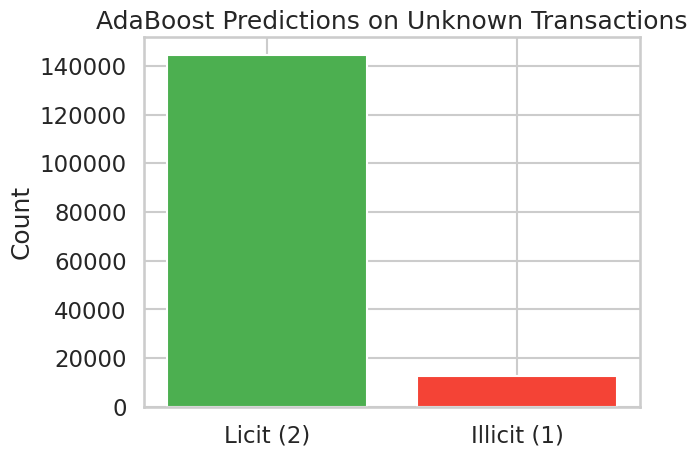

In [ ]:
X_unknown = df_unknown[feature_cols]
unknown_pred = ada_model.predict(X_unknown)

licit_count = np.count_nonzero(unknown_pred == 2)
illicit_count = np.count_nonzero(unknown_pred == 1)

plt.bar(["Licit (2)", "Illicit (1)"], [licit_count, illicit_count],
        color=['#4caf50','#f44336'])
plt.ylabel("Count")
plt.title("AdaBoost Predictions on Unknown Transactions")
plt.savefig(f"{save_dir}/ada_prediction.png", dpi=300, bbox_inches="tight")
plt.show()